### Forcasting using spatio-temporal data with combined Graph Convolution + LSTM model

The dynamics of many real-world phenomena are spatio-temporal in nature. Traffic forecasting is a quintessential example of spatio-temporal problems for which we present here a deep learning framework that models speed prediction using spatio-temporal data. The task is challenging due to two main inter-linked factors: (1) the complex spatial dependency on road networks, and (2) non-linear temporal dynamics with changing road conditions.

To address these challenge, here we  explore a neural network architecture that learns from both the spatial road network data and time-series of historical speed changes to forecast speeds on road segments at a future time. We use a 2-layer graph convolution network to leverage the graph structure of the road network. The output of the graph convolution network is fed into an LSTM based sequence to sequence model, that is jointly trained on the output of gcn and the historical speeds of a segment. 

The architecture of the gcn-lstm model is inpired by the paper: [T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction](https://ieeexplore.ieee.org/document/8809901).

The authors have made available the implementation of their model in their github [repo](https://github.com/lehaifeng/T-GCN).
There has been a few differences in the architecture proposed in the paper and the implementation with regards to the graph convolution component, these issues have been documented [here](https://github.com/lehaifeng/T-GCN/issues/18) and [here](https://github.com/lehaifeng/T-GCN/issues/14). Here we attempt at emulating the model as explained in the paperr. 

Concretetly, 
1. We use the 2-layer graph convolutional network (gcn) proposed by [Kipf & Welling (ICLR 2017)](http://arxiv.org/abs/1609.02907)
2. We stack the gcn with 1 layer of LSTM. The [TGCN](https://ieeexplore.ieee.org/document/8809901) uses GRU instead of LSTM. In practice there are not any remarkable differences between the two types of layers. We use LSTM as they are more frequently used.
3. We further add a Dropout and Dense layer as they experimentally showed improvement in performance and managing over-fitting.
#### References: 
* [T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction](https://ieeexplore.ieee.org/document/8809901)
* [https://github.com/lehaifeng/T-GCN](https://github.com/lehaifeng/T-GCN)
* [Semi-Supervised Classification with Graph Convolutional Networks](http://arxiv.org/abs/1609.02907)

In [1]:
import os
import sys
            
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

#### Data

We apply the gcn-lstm model to the ***Los-loop*** data. This traffic dataset
contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish
et al., 2014).  There are several processed versions of this dataset used by the research community working in Traffic forecasting space. 

This demo is based on the pre-processed version of the dataset used by the TGCN paper. It can be directly accessed from there [github repo](https://github.com/lehaifeng/T-GCN/tree/master/data). 

This dataset  contains traffic speeds from Mar.1 to Mar.7, 2012 of 207 sensors, recorded every 5 minutes. 

In order to use the model, we need:

* A N by N adjacency matrix, which describes the spatial relationship between roads,
* A N by D feature matrix, which describes the speed change over time on the roads.

We have provided the csv files of the weighted adjacency matrix and the time-series of speeds in the [/data](/data) directory with the demo for convenience. However, this may change in near future. The data can still be obtained by the TGCN repo nonetheless. 

A couple of other references for the same data albeit different time length are as follows: 

* [DIFFUSION CONVOLUTIONAL RECURRENT NEURAL NETWORK: DATA-DRIVEN TRAFFIC FORECASTING](https://github.com/liyaguang/DCRNN/tree/master/data): This dataset consists of 207 sensors and collect 4 months of data ranging from Mar 1st 2012 to Jun 30th 2012 for the experiment. It has some missing values.
* [ST-MetaNet: Urban Traffic Prediction from Spatio-Temporal Data Using Deep Meta Learning](https://github.com/panzheyi/ST-MetaNet/tree/master/traffic-prediction). This work uses the DCRNN pre-proccessed data.

#### Loading and pre-processing the data

In [2]:
from input_data import load_los_data, train_test_split, scale_data, sequence_data_preparation

In [3]:
data, adj = load_los_data('los')

In [4]:
num_nodes = data.shape[1]
time_len = data.shape[0]
print( "No. of sensors:", num_nodes, "\nNo of timesteps:",time_len)

No. of sensors: 207 
No of timesteps: 2016


#### Train/test split

In [5]:
train_rate = 0.8
train_data, test_data = train_test_split(data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (1612, 207)
Test data:  (404, 207)


#### Scaling

In [6]:
train_scaled, test_scaled = scale_data(train_data, test_data)

### Sequence data perparation for LSTM

* Each training observation are 10 historical speeds.
*Each training prediction is the speed 30 minutes later.

In [7]:
seq_len = 10
pre_len = 12

In [8]:
trainX, trainY, testX, testY = sequence_data_preparation(seq_len, pre_len, train_scaled, test_scaled)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1591, 10, 207)
(1591, 207)
(383, 10, 207)
(383, 207)


### StellarGraph Graph Convolution and LSTM model

In [9]:
from stellargraph.layer import Graph_Convolution_LSTM

In [10]:
gcn_lstm_model = Graph_Convolution_LSTM(num_nodes, adj)

In [11]:
gcn_lstm_model.compile(optimizer = "adam", loss = 'mae', metrics = ['mse'])

In [12]:
history = gcn_lstm_model.fit(trainX,trainY,epochs = 200, batch_size = 60, verbose = 0, validation_data = [testX,testY])
print("Train loss: ", history.history['loss'][-1], "\nTest loss:", history.history['val_loss'][-1])

Train loss:  0.04733292309837773 
Test loss: 0.06115331082524581


In [13]:
gcn_lstm_model.summary()

Model: "graph__convolution_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_convolution (GraphConv multiple                  43156     
_________________________________________________________________
graph_convolution_1 (GraphCo multiple                  43156     
_________________________________________________________________
lstm (LSTM)                  multiple                  326400    
_________________________________________________________________
dense (Dense)                multiple                  41607     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
Total params: 454,319
Trainable params: 368,621
Non-trainable params: 85,698
_________________________________________________________________


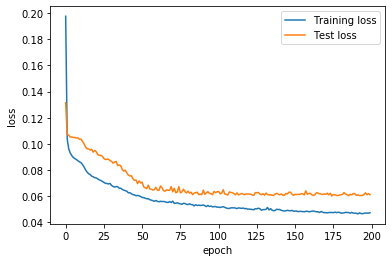

In [14]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [15]:
ythat = gcn_lstm_model.predict(trainX)
yhat = gcn_lstm_model.predict(testX)

##### Rescale values

In [16]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref=np.array(trainY*max_speed)
test_rescref=np.array(testY*max_speed)

In [17]:
## Rescale model predicted values
train_rescpred=np.array((ythat)*max_speed)
test_rescpred=np.array((yhat)*max_speed)

#### Measuring the performance of the model

To understand how well the model is performing, we compare it against a naive benchmark.

1. Naive prediction: using the most recently ***observed*** value as the predicted value. Note, that albeit being ***naive*** this is a very strong baseline to beat. Especially, when speeds are recorded at a 5 minutes granularity,  one does not expect many drastic changes within such a short period of time. Hence, for short-term predictions naive is a reasonable good guess.

#### Naive prediction benchmark (using latest observed value)

In [18]:
## Naive prediction benchmark (using previous observed value)

testnpred=np.array(testX).transpose(1,0,2)[-1] #picking the last speed of the 10 sequence for each segment in each sample
testnpredc=(testnpred)*max_speed

In [19]:
## Performance measures

seg_mael=[]
seg_masel=[]
seg_nmael=[]

for j in range(testX.shape[-1]):
    
    seg_mael.append(np.mean(np.abs(test_rescref.T[j]-test_rescpred.T[j]))) #Mean Absolute Error for NN
    seg_nmael.append(np.mean(np.abs(test_rescref.T[j]-testnpredc.T[j]))) #Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(seg_mael[-1]/seg_nmael[-1]) #Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)
        
print('Total (ave) MAE for NN: '+str(np.mean(np.array(seg_mael))))
print('Total (ave) MAE for naive prediction: '+str(np.mean(np.array(seg_nmael))))
print('Total (ave) MASE for per-segment NN/naive MAE: '+str(np.nanmean(np.array(seg_masel))))
print('...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.')

Total (ave) MAE for NN: 4.28073165944721
Total (ave) MAE for naive prediction: 5.877064444860809
Total (ave) MASE for per-segment NN/naive MAE: 0.7419703532884634
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


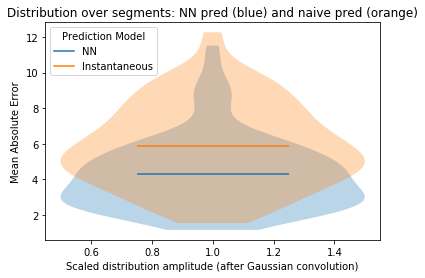

In [20]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
#xl = minsl

ax.violinplot(list(seg_mael),
                   showmeans=True,
                   showmedians=False,
              showextrema=False,
             widths=1.0)

ax.violinplot(list(seg_nmael),
                   showmeans=True,
                   showmedians=False,
              showextrema=False,
             widths=1.0)

line1 = mlines.Line2D([], [], label='NN')
line2 = mlines.Line2D([], [],color='C1', label='Instantaneous')

ax.set_xlabel('Scaled distribution amplitude (after Gaussian convolution)')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Distribution over segments: NN pred (blue) and naive pred (orange)')
plt.legend(handles=(line1,line2),title='Prediction Model',loc=2)
plt.show()

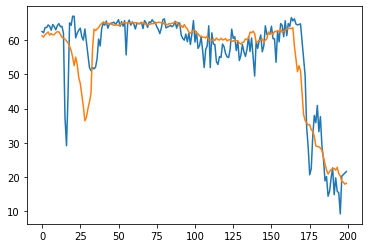

In [21]:
plt.plot(test_rescref[:200,100])
plt.plot(test_rescpred[:200,100])

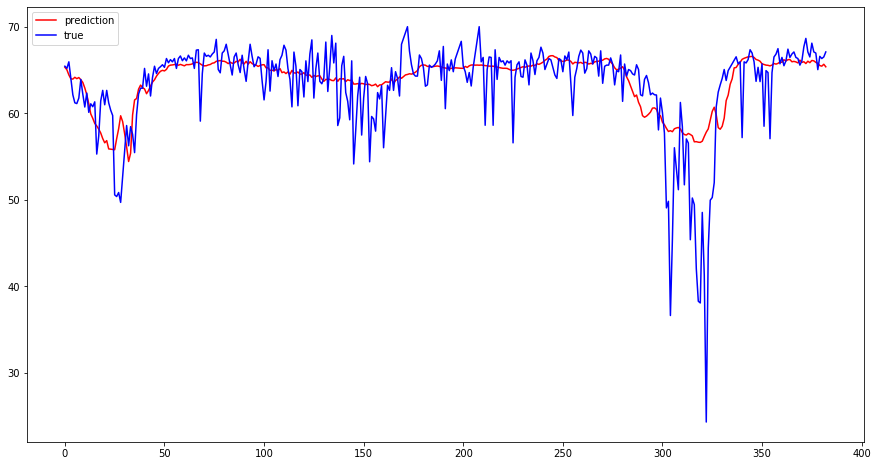

In [22]:
##all test result visualization
fig1 = plt.figure(figsize=(15,8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:,1]
a_true = test_rescref[:,1]
plt.plot(a_pred,'r-',label='prediction')
plt.plot(a_true,'b-',label='true')
plt.legend(loc='best',fontsize=10)
plt.show()